# EngiBench Latent Generative Models

This notebook downloads all trained generative models from WandB to a local checkpoints folder, then loads and uses them for generation.

**Workflow:**
1. Download all artifacts from a WandB project to `./checkpoints/` (ALREADY DONE IN GITHUB)
2. Load models from local checkpoints (no WandB dependency after download)
3. Generate designs using the loaded models

**Supported Models:**
- `cgan_cnn_2d`: Conditional GAN with CNN architecture
- `lvae_2d`: Least Volume Autoencoder
- `flow_2d`: Normalizing Flow (coupling layers)
- `diffusion_2d_cond`: Conditional Diffusion Model

**Supported Problems:**
- `beams2d`
- `heatconduction2d`
- `photonics2d`

In [1]:
from __future__ import annotations

import json
import os
from pathlib import Path
import random
import shutil

from engibench.utils.all_problems import BUILTIN_PROBLEMS
import matplotlib.pyplot as plt
from engibench_gen_models import CGANDiscriminator
from engibench_gen_models import CGANGenerator
from engibench_gen_models import CouplingLayer
from engibench_gen_models import DiffusionModel
from engibench_gen_models import LVAE_Encoder
from engibench_gen_models import LVAE_SNDecoder
from engibench_gen_models import NormalizingFlow
from engibench_gen_models import SimpleUNet
import numpy as np
import torch as th
from torch import nn
from torchvision import transforms

import wandb


/opt/anaconda3/envs/ml4me/lib/python3.12/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/ml4me/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Step 1: Download All WandB Artifacts to Local Checkpoints Folder (CAN SKIP ON GITHUB)

This cell downloads all model artifacts from the specified WandB project to a local `./checkpoints/` directory.
Each artifact is saved with its metadata (config, run info) for later loading.

In [2]:
# # ============ DOWNLOAD CONFIGURATION ============
# WANDB_PROJECT = "gen_models_engibench"
# WANDB_ENTITY = "ml4me"  # Your WandB entity
# CHECKPOINTS_DIR = "./checkpoints"  # Local directory to store checkpoints

# # Create checkpoints directory
# os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# print(f"Downloading artifacts from {WANDB_ENTITY}/{WANDB_PROJECT} to {CHECKPOINTS_DIR}...")

# # Initialize WandB API
# api = wandb.Api()

# downloaded_count = 0
# artifact_registry = {}  # Track all downloaded artifacts

# # Get all runs in the project to find their artifacts
# runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")

# print(f"Found {len(runs)} runs in project\n")

# for run in runs:
#     # Get artifacts logged by this run
#     try:
#         artifacts = run.logged_artifacts()
#     except Exception as e:
#         print(f"  Warning: Could not get artifacts for run {run.id}: {e}")
#         continue

#     for artifact in artifacts:
#         # Only process model artifacts
#         if artifact.type != "model":
#             continue

#         # Parse artifact name: {problem_id}_{model_type}
#         artifact_name = artifact.name.split(":")[0]  # Remove version suffix

#         # Parse seed from aliases
#         seed = None
#         for alias in artifact.aliases:
#             if alias.startswith("seed_"):
#                 seed = alias.split("_")[1]
#                 break

#         if seed is None:
#             print(f"  Skipping {artifact_name} (no seed alias found)")
#             continue

#         # Create directory for this artifact
#         artifact_dir = os.path.join(CHECKPOINTS_DIR, f"{artifact_name}_seed{seed}")

#         # Skip if already downloaded
#         if os.path.exists(artifact_dir) and os.path.exists(os.path.join(artifact_dir, "metadata.json")):
#             print(f"  ✓ Already exists: {artifact_name} (seed={seed})")

#             # Load metadata to registry
#             with open(os.path.join(artifact_dir, "metadata.json"), "r") as f:
#                 metadata = json.load(f)
#             artifact_registry[f"{artifact_name}_seed{seed}"] = metadata
#             continue

#         # Download artifact
#         print(f"  Downloading: {artifact_name} (seed={seed})...")
#         download_dir = artifact.download(root=artifact_dir)

#         # Get run config
#         if not hasattr(run, "config"):
#             print(f"    Warning: Could not retrieve run config for {artifact_name}")
#             continue

#         # Save metadata (config, problem_id, model_type, seed)
#         # Parse problem_id and model_type from artifact name
#         parts = artifact_name.split("_")
#         if len(parts) >= 2:
#             # Handle cases like "beams2d_cgan_cnn_2d" -> problem="beams2d", model="cgan_cnn_2d"
#             # Find where the model type starts (after the problem ID)
#             known_problems = ["beams2d", "heatconduction2d", "thermoelastic2d", "photonics2d"]
#             problem_id = None
#             for prob in known_problems:
#                 if artifact_name.startswith(prob):
#                     problem_id = prob
#                     model_type = artifact_name[len(prob)+1:]  # +1 for underscore
#                     break

#             if problem_id is None:
#                 print(f"    Warning: Could not parse problem_id from {artifact_name}")
#                 problem_id = "unknown"
#                 model_type = artifact_name
#         else:
#             problem_id = "unknown"
#             model_type = artifact_name

#         metadata = {
#             "artifact_name": artifact_name,
#             "problem_id": problem_id,
#             "model_type": model_type,
#             "seed": int(seed),
#             "config": dict(run.config),
#             "checkpoint_dir": artifact_dir,
#         }

#         # Save metadata to JSON
#         with open(os.path.join(artifact_dir, "metadata.json"), "w") as f:
#             json.dump(metadata, f, indent=2)

#         artifact_registry[f"{artifact_name}_seed{seed}"] = metadata
#         downloaded_count += 1
#         print(f"    ✓ Downloaded to {artifact_dir}")

# print(f"\n{'='*60}")
# print(f"Download complete! {downloaded_count} new artifacts downloaded.")
# print(f"Total artifacts available: {len(artifact_registry)}")
# print(f"\nArtifact Registry:")
# for key, meta in artifact_registry.items():
#     print(f"  - {key}: {meta['problem_id']} | {meta['model_type']}")

## Step 2: Load Artifact Registry from Local Checkpoints

This cell scans the `./checkpoints/` directory and builds a registry of available models.
Use this if you've already downloaded artifacts and want to reload them without re-downloading.

In [3]:
# ============ AUTO-UNZIP CHECKPOINTS ============
import zipfile

CHECKPOINTS_ZIP = "./engibench_checkpoints.zip"
CHECKPOINTS_DIR = "./checkpoints"

# Check if zip exists and checkpoints directory doesn't exist or is empty
if os.path.exists(CHECKPOINTS_ZIP):
    if not os.path.exists(CHECKPOINTS_DIR) or len(os.listdir(CHECKPOINTS_DIR)) == 0:
        print(f"Extracting checkpoints from {CHECKPOINTS_ZIP}...")
        os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
        with zipfile.ZipFile(CHECKPOINTS_ZIP, 'r') as zip_ref:
            zip_ref.extractall(CHECKPOINTS_DIR)
        print(f"✓ Checkpoints extracted to {CHECKPOINTS_DIR}\n")
    else:
        print(f"Checkpoints directory already exists, skipping extraction\n")
elif not os.path.exists(CHECKPOINTS_DIR):
    print(f"Warning: Neither {CHECKPOINTS_ZIP} nor {CHECKPOINTS_DIR} found!")
    print(f"Please ensure the checkpoint zip file is available.\n")

# ============ LOAD LOCAL CHECKPOINTS ============
# Build artifact registry from local checkpoints
artifact_registry = {}

if not os.path.exists(CHECKPOINTS_DIR):
    print(f"Checkpoints directory not found: {CHECKPOINTS_DIR}")
    print("Please run the download cell first (Step 1)")
else:
    print(f"Loading checkpoints from {CHECKPOINTS_DIR}...\n")
    
    for item in os.listdir(CHECKPOINTS_DIR):
        item_path = os.path.join(CHECKPOINTS_DIR, item)
        
        # Check if it's a directory with metadata
        if os.path.isdir(item_path):
            metadata_path = os.path.join(item_path, "metadata.json")
            
            if os.path.exists(metadata_path):
                with open(metadata_path, "r") as f:
                    metadata = json.load(f)
                
                artifact_key = f"{metadata['artifact_name']}_seed{metadata['seed']}"
                artifact_registry[artifact_key] = metadata
                print(f"  ✓ Loaded: {artifact_key}")
    
    print(f"\n{'='*60}")
    print(f"Found {len(artifact_registry)} checkpoints")
    print(f"\nAvailable Models:")
    
    # Group by problem_id
    by_problem = {}
    for key, meta in artifact_registry.items():
        problem_id = meta['problem_id']
        if problem_id not in by_problem:
            by_problem[problem_id] = []
        by_problem[problem_id].append((meta['model_type'], meta['seed']))
    
    for problem_id, models in sorted(by_problem.items()):
        print(f"\n  {problem_id}:")
        for model_type, seed in sorted(models):
            print(f"    - {model_type} (seed={seed})")

Checkpoints directory already exists, skipping extraction

Loading checkpoints from ./checkpoints...

  ✓ Loaded: heatconduction2d_cgan_cnn_2d_seed1
  ✓ Loaded: heatconduction2d_lvae_2d_seed1
  ✓ Loaded: photonics2d_lvae_2d_seed2
  ✓ Loaded: beams2d_flow_2d_seed1
  ✓ Loaded: photonics2d_cgan_cnn_2d_seed1
  ✓ Loaded: beams2d_lvae_2d_seed1
  ✓ Loaded: heatconduction2d_flow_2d_seed1
  ✓ Loaded: beams2d_diffusion_2d_cond_seed1
  ✓ Loaded: heatconduction2d_lvae_2d_seed2
  ✓ Loaded: photonics2d_lvae_2d_seed1
  ✓ Loaded: photonics2d_diffusion_2d_cond_seed1
  ✓ Loaded: photonics2d_flow_2d_seed1
  ✓ Loaded: beams2d_lvae_2d_seed2
  ✓ Loaded: heatconduction2d_diffusion_2d_cond_seed1
  ✓ Loaded: beams2d_cgan_cnn_2d_seed1

Found 15 checkpoints

Available Models:

  beams2d:
    - cgan_cnn_2d (seed=1)
    - diffusion_2d_cond (seed=1)
    - flow_2d (seed=1)
    - lvae_2d (seed=1)
    - lvae_2d (seed=2)

  heatconduction2d:
    - cgan_cnn_2d (seed=1)
    - diffusion_2d_cond (seed=1)
    - flow_2d (see

## Configuration for Generation

In [4]:
# ============ USER CONFIGURATION ============
MODEL_TYPE = "cgan_cnn_2d"  # Options: "cgan_cnn_2d", "lvae_2d", "flow_2d", "diffusion_2d_cond"
PROBLEM_ID = "beams2d"      # Options: "beams2d", "heatconduction2d", "photonics2d"
SEED = 1                    # Seed used during training

# Generation parameters
N_SAMPLES = 100              # Number of designs to generate
DEVICE = "cuda" if th.cuda.is_available() else ("mps" if th.backends.mps.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"Model: {MODEL_TYPE}")
print(f"Problem: {PROBLEM_ID}")
print(f"Seed: {SEED}")

# Look up checkpoint in registry
checkpoint_key = f"{PROBLEM_ID}_{MODEL_TYPE}_seed{SEED}"

if checkpoint_key not in artifact_registry:
    print(f"\n❌ ERROR: Checkpoint not found: {checkpoint_key}")
    print(f"\nAvailable checkpoints:")
    for key in artifact_registry.keys():
        print(f"  - {key}")
    raise ValueError(f"Checkpoint not found: {checkpoint_key}")

checkpoint_metadata = artifact_registry[checkpoint_key]
checkpoint_dir = checkpoint_metadata["checkpoint_dir"]
run_config = checkpoint_metadata["config"]

print(f"\n✓ Found checkpoint: {checkpoint_dir}")
print(f"\nModel Configuration:")
for key, value in run_config.items():
    print(f"  {key}: {value}")

Using device: mps
Model: cgan_cnn_2d
Problem: beams2d
Seed: 1

✓ Found checkpoint: ./checkpoints/beams2d_cgan_cnn_2d_seed1

Model Configuration:
  b1: 0.5
  b2: 0.999
  algo: cgan_cnn_2d
  seed: 1
  track: True
  lr_gen: 0.0001
  lr_disc: 0.0004
  n_epochs: 1000
  batch_size: 32
  latent_dim: 32
  problem_id: beams2d
  save_model: True
  wandb_entity: ml4me
  wandb_project: gen_models_engibench
  sample_interval: 400


## Load Problem and Setup

In [5]:
# Load problem from EngiBench
problem = BUILTIN_PROBLEMS[PROBLEM_ID]()
problem.reset(seed=SEED)

design_shape = problem.design_space.shape
n_conds = len(problem.conditions_keys)

print(f"Design shape: {design_shape}")
print(f"Number of conditions: {n_conds}")
print(f"Condition keys: {problem.conditions_keys}")

# Set random seeds for reproducibility
th.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Design shape: (50, 100)
Number of conditions: 4
Condition keys: ['volfrac', 'rmin', 'forcedist', 'overhang_constraint']


## Sample Target Conditions

Generate random target conditions for generation.

In [6]:
rng = np.random.default_rng(SEED)

# Extract the conditions
dataset = problem.dataset["test"]
conditions_ds = dataset.select_columns(problem.conditions_keys)

# Sample conditions and test_ds designs at random indices
selected_indices = rng.choice(len(dataset), N_SAMPLES, replace=True)
sampled_conditions = conditions_ds.select(selected_indices)
sampled_designs_np = np.array(dataset["optimal_design"])[selected_indices]

# Create tensor for conditions to be used in the generator
conditions_tensor = th.tensor(list(sampled_conditions[:].values()), dtype=th.float32, device=DEVICE).T
conditions_np = np.array(list(sampled_conditions[:].values()))

## Load Model from Local Checkpoint

This section loads the trained model from the local checkpoint directory.

In [7]:
if MODEL_TYPE == "cgan_cnn_2d":
    # ========== CGAN CNN 2D ==========
    ckpt_path = os.path.join(checkpoint_dir, "generator_barebones.pth")
    
    # Create generator
    generator = CGANGenerator(
        latent_dim=run_config["latent_dim"],
        n_conds=n_conds,
        design_shape=design_shape
    )
    
    # Load weights
    generator.load_state_dict(th.load(ckpt_path, map_location=DEVICE))
    generator.to(DEVICE)
    generator.eval()
    
    print(f"Loaded CGAN generator with latent_dim={run_config['latent_dim']}")
    
elif MODEL_TYPE == "lvae_2d":
    # ========== LVAE 2D ==========
    ckpt_path = os.path.join(checkpoint_dir, "lvae_barebones.pth")
    
    # Create encoder and decoder
    encoder = LVAE_Encoder(
        latent_dim=run_config["latent_dim"],
        resize_dimensions=run_config.get("resize_dimensions", (100, 100))
    )
    decoder = LVAE_SNDecoder(
        latent_dim=run_config["latent_dim"],
        design_shape=design_shape
    )
    
    # Load weights
    checkpoint = th.load(ckpt_path, map_location=DEVICE)
    encoder.load_state_dict(checkpoint["encoder"])
    decoder.load_state_dict(checkpoint["decoder"])
    encoder.to(DEVICE)
    decoder.to(DEVICE)
    encoder.eval()
    decoder.eval()
    
    print(f"Loaded LVAE with latent_dim={run_config['latent_dim']}")
    
elif MODEL_TYPE == "flow_2d":
    # ========== Normalizing Flow 2D ==========
    ckpt_path = os.path.join(checkpoint_dir, "flow_barebones.pth")
    
    # Design needs to be flattened for flow
    design_dim = int(np.prod((100,100)))
    
    # Create flow model
    flow = NormalizingFlow(
        dim=design_dim,
        n_flows=run_config["n_flows"],
        hidden_dim=run_config["hidden_dim"],
        n_conds=n_conds
    )
    
    # Load weights
    flow.load_state_dict(th.load(ckpt_path, map_location=DEVICE))
    flow.to(DEVICE)
    flow.eval()
    
    print(f"Loaded Flow with n_flows={run_config['n_flows']}, hidden_dim={run_config['hidden_dim']}")
    
elif MODEL_TYPE == "diffusion_2d_cond":
    # ========== Diffusion 2D Conditional ==========
    ckpt_path = os.path.join(checkpoint_dir, "diffusion_barebones.pth")
    
    # Create U-Net model
    unet = SimpleUNet(n_conds=n_conds)
    
    # Load weights
    unet.load_state_dict(th.load(ckpt_path, map_location=DEVICE))
    unet.to(DEVICE)
    unet.eval()
    
    # Create diffusion helper
    diffusion = DiffusionModel(
        num_timesteps=run_config["num_timesteps"],
        beta_start=run_config["beta_start"],
        beta_end=run_config["beta_end"],
        device=DEVICE
    )
    
    print(f"Loaded Diffusion with num_timesteps={run_config['num_timesteps']}")
    
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

print("\nModel loaded successfully from local checkpoint!")

Loaded CGAN generator with latent_dim=32

Model loaded successfully from local checkpoint!


## Generate Designs

Generate designs conditioned on the sampled conditions.

In [8]:
with th.no_grad():
    if MODEL_TYPE == "cgan_cnn_2d":
        # Sample noise
        z = th.randn((N_SAMPLES, run_config["latent_dim"], 1, 1), device=DEVICE)
        # Reshape conditions for CGAN
        c = conditions_tensor.unsqueeze(-1).unsqueeze(-1)  # (N, n_conds, 1, 1)
        # Generate
        gen_designs = generator(z, c)
        gen_designs_np = gen_designs.cpu().numpy()
        gen_designs_np = gen_designs_np.reshape(N_SAMPLES, *design_shape)
        
    elif MODEL_TYPE == "lvae_2d":
        # Sample random latent codes
        z = th.randn((N_SAMPLES, run_config["latent_dim"]), device=DEVICE)
        # Generate (LVAE is unconditional, ignores conditions)
        gen_designs = decoder(z)
        gen_designs_np = gen_designs.cpu().numpy()
        gen_designs_np = gen_designs_np.reshape(N_SAMPLES, *design_shape)
        print("Note: LVAE is unconditional - generated designs do not match target conditions")
        
    elif MODEL_TYPE == "flow_2d":
        resize_to_original = transforms.Resize(design_shape)
        samples = flow.sample(N_SAMPLES, conditions_tensor)
        # Reshape to (100, 100) then resize to original shape
        samples = samples.view(-1, 1, 100, 100)
        samples = resize_to_original(samples).squeeze(1)  # Back to (N, H, W)
        gen_designs_np = samples.cpu().numpy()
        print("Note: Flow may be unconditional - check training config")
        
    elif MODEL_TYPE == "diffusion_2d_cond":
        resize_to_original = transforms.Resize(design_shape)
        # Start from pure noise
        x_t = th.randn((N_SAMPLES, 1, 100, 100), device=DEVICE)
        
        # Reverse diffusion process
        for t in reversed(range(diffusion.num_timesteps)):
            x_t = diffusion.p_sample(unet, x_t, t, conditions_tensor)
            
            # Progress indicator
            if (diffusion.num_timesteps - t) % 50 == 0:
                print(f"Denoising step {diffusion.num_timesteps - t}/{diffusion.num_timesteps}")
        
        samples = resize_to_original(x_t)
        gen_designs_np = samples.cpu().numpy()
        gen_designs_np = gen_designs_np.reshape(N_SAMPLES, *design_shape)

# Clip to valid range [0, 1] (typical for binary/density designs)
gen_designs_np = np.clip(gen_designs_np, 0.0, 1.0)

print(f"\nGenerated {N_SAMPLES} designs with shape {gen_designs_np.shape}")


Generated 100 designs with shape (100, 50, 100)


## Visualize Generated Designs

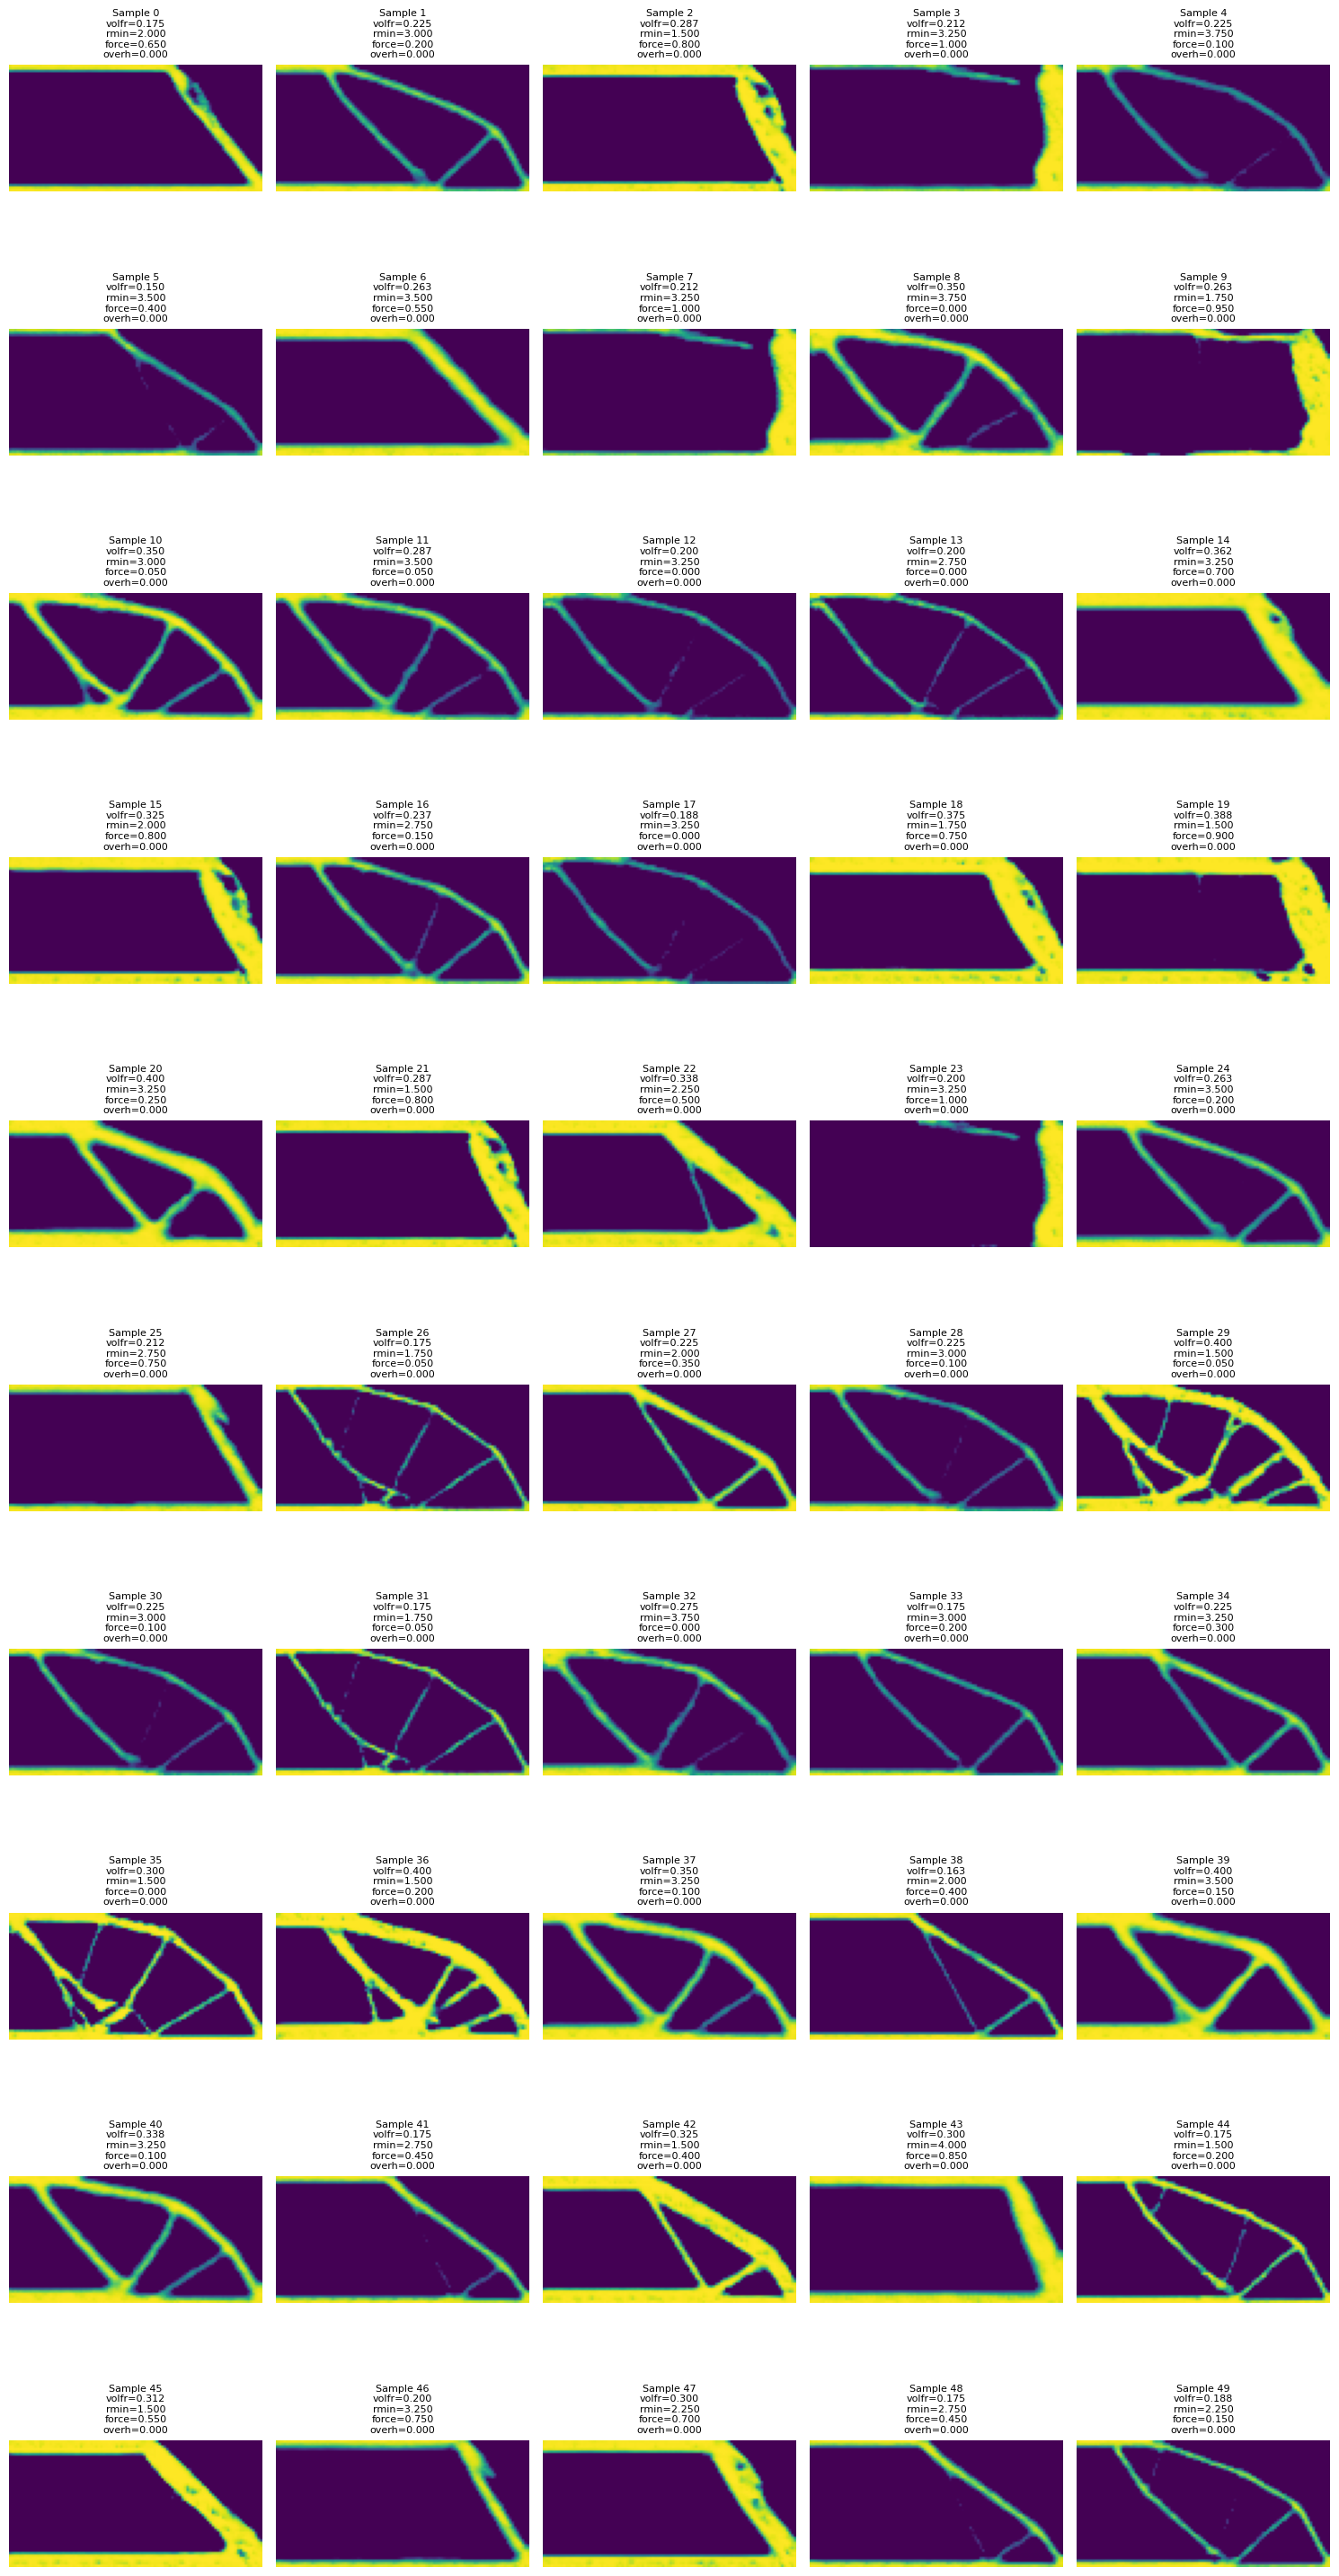


Showing 50 of 100 generated designs


In [9]:
# Plot generated designs
n_cols = min(5, N_SAMPLES)
n_rows = min(10, (N_SAMPLES + n_cols - 1) // n_cols)  # Limit to 10 rows for display
n_display = min(N_SAMPLES, n_rows * n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
if n_cols == 1:
    axes = axes.reshape(-1, 1)

for i in range(n_display):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    # Plot design
    im = ax.imshow(gen_designs_np[i], cmap='viridis', vmin=0, vmax=1)
    
    # Add title with conditions
    cond_str = "\n".join([f"{k[:5]}={conditions_np[j, i]:.3f}"
                          for j, k in enumerate(problem.conditions_keys)])
    ax.set_title(f"Sample {i}\n{cond_str}", fontsize=8)
    ax.axis('off')

# Hide extra subplots
for i in range(n_display, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

if N_SAMPLES > n_display:
    print(f"\nShowing {n_display} of {N_SAMPLES} generated designs")

In [10]:
from ipywidgets import interact, FloatSlider, VBox, HBox, Output, Label
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Sort conditions by each condition key
sorted_indices = {}
sorted_conditions = {}

for j, key in enumerate(problem.conditions_keys):
    # Get condition values for this key
    cond_values = conditions_np[j, :]
    # Sort indices by increasing condition value
    sorted_idx = np.argsort(cond_values)
    sorted_indices[key] = sorted_idx
    sorted_conditions[key] = cond_values[sorted_idx]

print("Sorted conditions by each key:")
for key in problem.conditions_keys:
    print(f"\n{key}:")
    print(f"  Min: {sorted_conditions[key].min():.4f}")
    print(f"  Max: {sorted_conditions[key].max():.4f}")
    print(f"  Range: {sorted_conditions[key]}")

# Create sliders for each condition
sliders = {}
for j, key in enumerate(problem.conditions_keys):
    min_val = float(sorted_conditions[key].min())
    max_val = float(sorted_conditions[key].max())
    
    sliders[key] = FloatSlider(
        value=min_val,
        min=min_val,
        max=max_val,
        step=(max_val - min_val) / 100,
        description=f'{key}:',
        continuous_update=True,
        readout=True,
        readout_format='.4f',
    )

# Function to find the closest sample to slider values
def find_closest_sample(**slider_values):
    # Calculate distance to each sample
    distances = np.zeros(N_SAMPLES)
    
    for j, key in enumerate(problem.conditions_keys):
        target_value = slider_values[key]
        # Normalize by range to give equal weight to each condition
        cond_range = sorted_conditions[key].max() - sorted_conditions[key].min()
        if cond_range > 0:
            distances += ((conditions_np[j, :] - target_value) / cond_range) ** 2
        else:
            distances += (conditions_np[j, :] - target_value) ** 2
    
    # Find closest sample
    closest_idx = np.argmin(distances)
    
    # Clear and display
    clear_output(wait=True)
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display generated design from original model
    axes[0].imshow(gen_designs_np[closest_idx], cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title(f'{MODEL_TYPE}\n(Closest Match)', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    
    # Display dataset design
    axes[1].imshow(sampled_designs_np[closest_idx], cmap='viridis', vmin=0, vmax=1)
    axes[1].set_title('Dataset Design\n(Closest Match)', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Add condition information as suptitle
    cond_info = []
    for j, key in enumerate(problem.conditions_keys):
        target = slider_values[key]
        actual = conditions_np[j, closest_idx]
        cond_info.append(f"{key}: target={target:.4f}, actual={actual:.4f}")
    
    fig.suptitle(f"Sample {closest_idx} | " + " | ".join(cond_info), 
                 fontsize=11, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nClosest sample: {closest_idx}")
    print(f"Distance: {np.sqrt(distances[closest_idx]):.6f}")
    print(f"\nCondition comparison:")
    for j, key in enumerate(problem.conditions_keys):
        target = slider_values[key]
        actual = conditions_np[j, closest_idx]
        diff = actual - target
        print(f"  {key:15s}: target={target:8.4f}, actual={actual:8.4f}, diff={diff:+8.4f}")

# Create interactive widget
interact(find_closest_sample, **sliders)

Sorted conditions by each key:

volfrac:
  Min: 0.1500
  Max: 0.4000
  Range: [0.15   0.15   0.1625 0.1625 0.1625 0.175  0.175  0.175  0.175  0.175
 0.175  0.175  0.175  0.175  0.175  0.1875 0.1875 0.1875 0.1875 0.1875
 0.1875 0.2    0.2    0.2    0.2    0.2    0.2125 0.2125 0.2125 0.225
 0.225  0.225  0.225  0.225  0.225  0.225  0.2375 0.25   0.2625 0.2625
 0.2625 0.2625 0.2625 0.2625 0.2625 0.2625 0.275  0.275  0.275  0.275
 0.2875 0.2875 0.2875 0.2875 0.2875 0.2875 0.2875 0.3    0.3    0.3
 0.3    0.3    0.3125 0.3125 0.325  0.325  0.325  0.325  0.325  0.325
 0.325  0.325  0.325  0.325  0.325  0.3375 0.3375 0.3375 0.35   0.35
 0.35   0.35   0.35   0.35   0.35   0.3625 0.375  0.375  0.375  0.3875
 0.3875 0.3875 0.3875 0.3875 0.3875 0.4    0.4    0.4    0.4    0.4   ]

rmin:
  Min: 1.5000
  Max: 4.0000
  Range: [1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.75
 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 2.   2.   2.   2.   2.   2.
 2.   2.   2.25 2.25 2.25 2.25 2.25 

interactive(children=(FloatSlider(value=0.15, description='volfrac:', max=0.4, min=0.15, readout_format='.4f',…

<function __main__.find_closest_sample(**slider_values)>

## Retrain a 1D model with latent codes from LVAE

In [11]:
## Configuration for Retraining

# ============ RETRAINING CONFIGURATION ============
RETRAIN_MODEL_TYPE = "cgan_1d"  # Model to retrain (supports: "cgan_1d")
LVAE_SEED = 1                       # Seed for LVAE encoder to load
LVAE_WANDB_PROJECT = "gen_models_engibench"
LVAE_WANDB_ENTITY = "ml4me"

# Retraining hyperparameters
RETRAIN_EPOCHS = 100
RETRAIN_BATCH_SIZE = 128
RETRAIN_LR_GEN = 1e-4
RETRAIN_LR_DISC = 4e-4
RETRAIN_LATENT_DIM = 32  # Latent dimension for the model being retrained
RETRAIN_SEED = 1        # New seed for retraining

# Look up LVAE checkpoint in registry
checkpoint_key = f"{PROBLEM_ID}_lvae_2d_seed{LVAE_SEED}"

if checkpoint_key not in artifact_registry:
    print(f"\n❌ ERROR: Checkpoint not found: {checkpoint_key}")
    print(f"\nAvailable checkpoints:")
    for key in artifact_registry.keys():
        print(f"  - {key}")
    raise ValueError(f"Checkpoint not found: {checkpoint_key}")

checkpoint_metadata = artifact_registry[checkpoint_key]
checkpoint_dir = checkpoint_metadata["checkpoint_dir"]
run_config = checkpoint_metadata["config"]

print(f"\n✓ Found checkpoint: {checkpoint_dir}")
print(f"\nModel Configuration:")
for key, value in run_config.items():
    print(f"  {key}: {value}")



✓ Found checkpoint: ./checkpoints/beams2d_lvae_2d_seed1

Model Configuration:
  lr: 0.0001
  eta: 0.0001
  algo: lvae_2d
  seed: 1
  track: True
  w_rec: 1
  w_vol: 0.01
  n_epochs: 1000
  batch_size: 128
  latent_dim: 10
  problem_id: beams2d
  save_model: True
  wandb_entity: ml4me
  wandb_project: gen_models_engibench
  sample_interval: 500
  resize_dimensions: [100, 100]


In [12]:
# ========== LVAE 2D ==========
ckpt_path = os.path.join(checkpoint_dir, "lvae_barebones.pth")
    
# Create encoder and decoder
lvae_encoder = LVAE_Encoder(
    latent_dim=run_config["latent_dim"],
    resize_dimensions=run_config.get("resize_dimensions", (100, 100))
).to(DEVICE)
lvae_decoder = LVAE_SNDecoder(
    latent_dim=run_config["latent_dim"],
    design_shape=design_shape
).to(DEVICE)

# Load weights
lvae_checkpoint = th.load(ckpt_path, map_location=DEVICE)
lvae_encoder.load_state_dict(lvae_checkpoint["encoder"])
lvae_decoder.load_state_dict(lvae_checkpoint["decoder"])
lvae_encoder.eval()
lvae_decoder.eval()

print(f"Loaded LVAE encoder and decoder with latent_dim={run_config['latent_dim']}")

Loaded LVAE encoder and decoder with latent_dim=10


Dataset size: 3880
Design shape: torch.Size([3880, 1, 50, 100])
Conditions shape: torch.Size([3880, 4])

Encoding dataset into LVAE latent space...
Latent codes shape: torch.Size([3880, 10])
Latent codes mean: 0.7851
Latent codes std: 6.1088


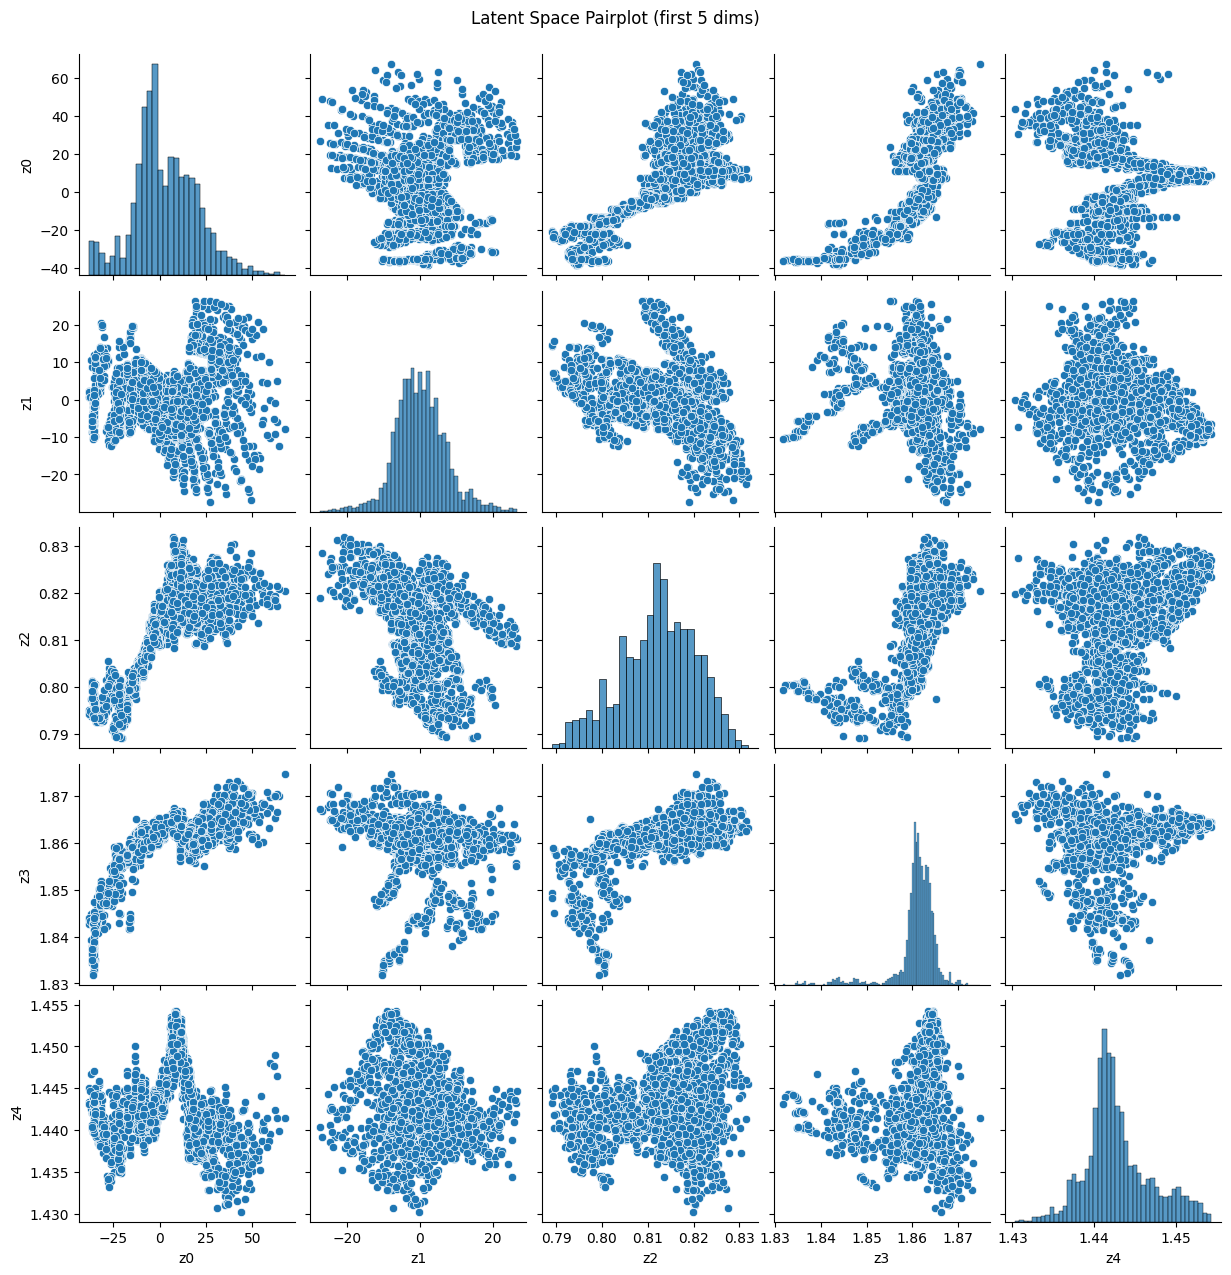

In [ ]:
import pandas as pd
import seaborn as sns

## Encode Dataset into Latent Codes

# Load the training dataset
training_ds = problem.dataset.with_format("torch", device=DEVICE)["train"]
designs_tensor = training_ds["optimal_design"][:].unsqueeze(1).float()  # Add channel dim

print(f"Dataset size: {len(designs_tensor)}")
print(f"Design shape: {designs_tensor.shape}")

# Extract conditions
conditions_list = [training_ds[key][:] for key in problem.conditions_keys]
conditions_tensor_train = th.stack(conditions_list, dim=1).float()

print(f"Conditions shape: {conditions_tensor_train.shape}")

# Encode all designs into latent space
print("\nEncoding dataset into LVAE latent space...")
with th.no_grad():
    latent_codes = lvae_encoder(designs_tensor)

print(f"Latent codes shape: {latent_codes.shape}")
print(f"Latent codes mean: {latent_codes.mean().item():.4f}")
print(f"Latent codes std: {latent_codes.std().item():.4f}")

# Show only the first 5 latent dimensions (or fewer if latent has <5 dims)
n_show = min(5, latent_codes.shape[1])
# Sort latent dimensions by increasing standard deviation and select first n_show dims
stds = latent_codes.std(dim=0).cpu().numpy()
# Select the dimensions with the largest standard deviations
order = np.argsort(stds)[::-1]  # descending order
selected_dims = order[:n_show]
arr = latent_codes.cpu().detach().numpy()[:, selected_dims]
cols = [f"z{i}" for i in range(n_show)]
df = pd.DataFrame(arr, columns=cols)

sns.pairplot(df)
plt.suptitle(f'Latent Space Pairplot (top {n_show} dims)', y=1.02)
plt.show()


Normalization statistics:
  Original - Mean: 0.7851, Std: 6.1088
  Original - Range: [-38.3321, 67.5771]
  Normalized - Mean: 0.0000, Std: 0.9999
  Normalized - Range: [-5.8380, 5.0390]

Stored normalization parameters for denormalization during generation


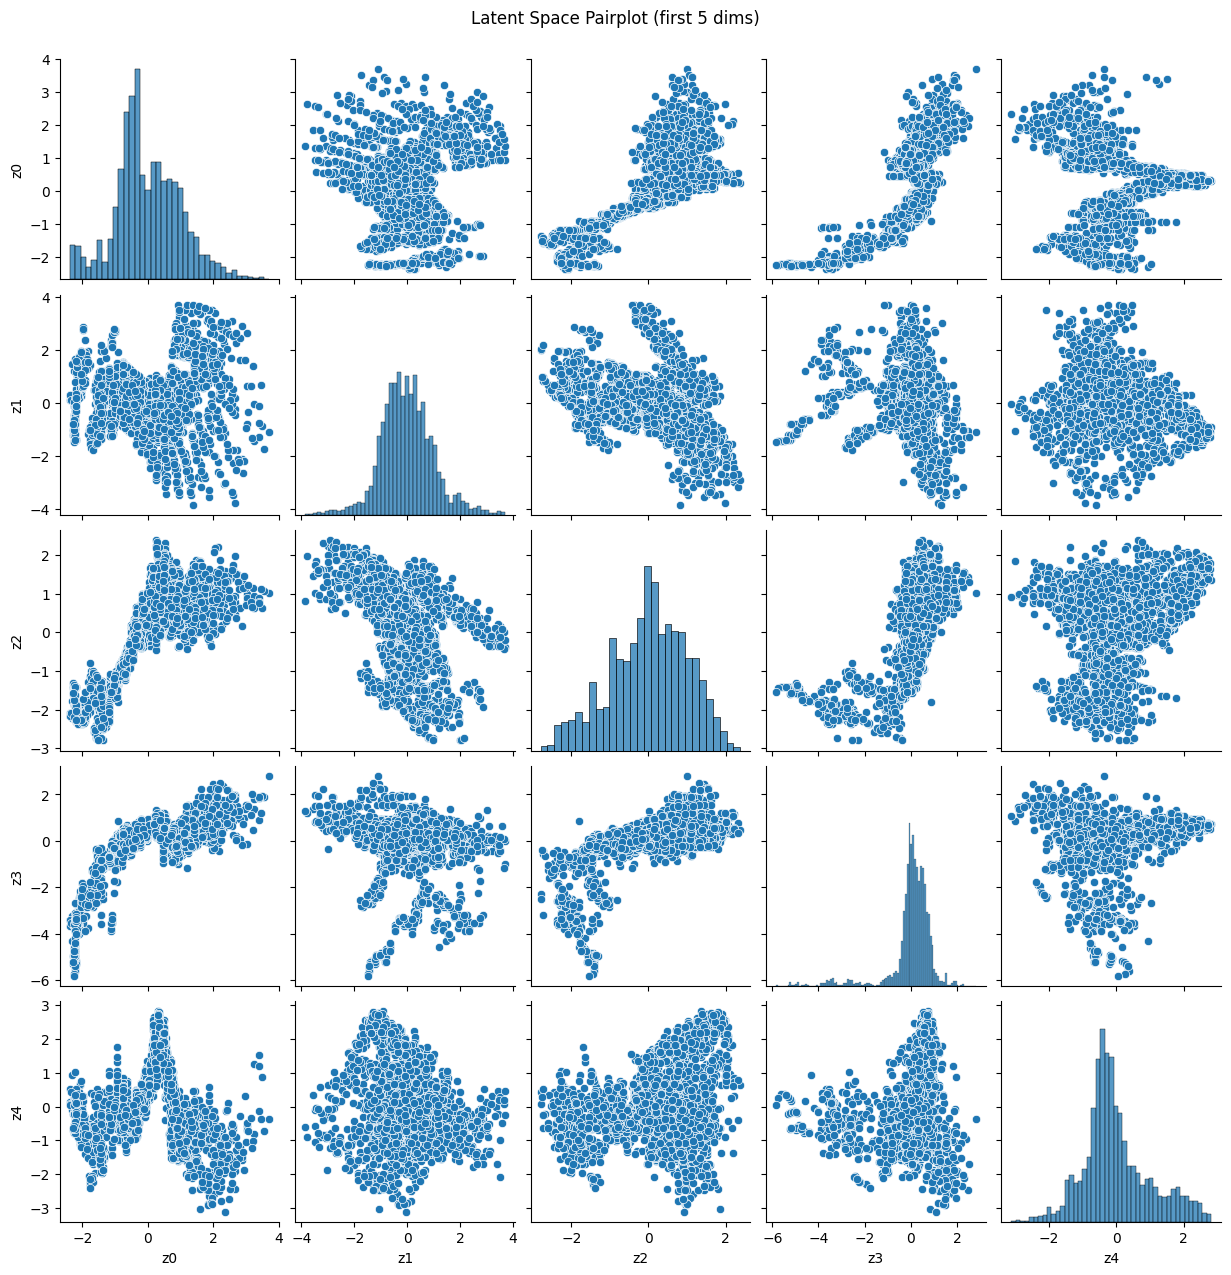

In [17]:
## Normalize Latent Codes

# IMPORTANT: Normalize latent codes to prevent distribution mismatch with generator output
# The LVAE encoder produces unbounded latent values, but we'll normalize to ~N(0,1)
# This allows the generator (without Tanh) to match the distribution

latent_mean = latent_codes.mean(dim=0, keepdim=True)
latent_std = latent_codes.std(dim=0, keepdim=True)

# Normalize latent codes
latent_codes_normalized = (latent_codes - latent_mean) / (latent_std + 1e-8)

print(f"\nNormalization statistics:")
print(f"  Original - Mean: {latent_codes.mean().item():.4f}, Std: {latent_codes.std().item():.4f}")
print(f"  Original - Range: [{latent_codes.min().item():.4f}, {latent_codes.max().item():.4f}]")
print(f"  Normalized - Mean: {latent_codes_normalized.mean().item():.4f}, Std: {latent_codes_normalized.std().item():.4f}")
print(f"  Normalized - Range: [{latent_codes_normalized.min().item():.4f}, {latent_codes_normalized.max().item():.4f}]")

# Store normalization parameters for later denormalization during generation
print(f"\nStored normalization parameters for denormalization during generation")

# Show only the first 5 latent dimensions (or fewer if latent has <5 dims)
n_show = min(5, latent_codes_normalized.shape[1])
arr = latent_codes_normalized.cpu().detach().numpy()[:, selected_dims]
cols = [f"z{i}" for i in range(n_show)]
df = pd.DataFrame(arr, columns=cols)

sns.pairplot(df)
plt.suptitle(f'Latent Space Pairplot (first {n_show} dims)', y=1.02)
plt.show()

In [171]:
class CGAN1D_Generator(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_conds: int,
        design_shape: tuple[int, ...],
    ):
        super().__init__()
        self.design_shape = design_shape  # Store design shape

        def block(in_feat: int, out_feat: int, *, normalize: bool = True) -> list[nn.Module]:
            layers: list[nn.Module] = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_conds, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(design_shape))),
        )

    def forward(self, z: th.Tensor, conds: th.Tensor) -> th.Tensor:
        """Forward pass for the generator.

        Args:
            z (th.Tensor): Latent space input tensor.
            conds (th.Tensor): Condition tensor.

        Returns:
            th.Tensor: Generated design tensor.
        """
        gen_input = th.cat((z, conds), -1)
        design = self.model(gen_input)
        return design.view(design.size(0), *self.design_shape)


class CGAN1D_Discriminator(nn.Module):
    def __init__(self, design_shape: tuple[int, ...], n_conds: int):
        super().__init__()
        self.n_conds=n_conds
        
        # ADDED: Spectral normalization for Lipschitz constraint and training stability
        from torch.nn.utils.parametrizations import spectral_norm
        
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(int(np.prod(design_shape)) + n_conds, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(512, 512)),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(512, 512)),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),  # Final layer typically not normalized
            nn.Sigmoid()
        )

    def forward(self, design: th.Tensor, conds: th.Tensor) -> th.Tensor:
        design_flat = design.view(design.size(0), -1)
        d_in = th.cat((design_flat, conds), -1)
        return self.model(d_in)

In [172]:
## Setup Retraining Models and Optimizers

# Set random seeds for retraining
th.manual_seed(RETRAIN_SEED)
np.random.seed(RETRAIN_SEED)
random.seed(RETRAIN_SEED)

training_ds = problem.dataset.with_format("torch", device=DEVICE)["train"]

# Use normalized latent codes instead of raw latent codes
retrain_ds = th.utils.data.TensorDataset(
        latent_codes_normalized,  # Use normalized latents
        *[training_ds[key][:] for key in problem.conditions_keys],
    )

dataloader = th.utils.data.DataLoader(
        retrain_ds,
        batch_size=RETRAIN_BATCH_SIZE,
        shuffle=True,
    )

# Initialize new generator and discriminator
retrain_generator = CGAN1D_Generator(
    latent_dim=RETRAIN_LATENT_DIM,
    n_conds=n_conds,
    design_shape=(10,)
).to(DEVICE)

retrain_discriminator = CGAN1D_Discriminator(
    n_conds=n_conds,
    design_shape=(10,)
).to(DEVICE)

# Initialize optimizers
from torch.optim import Adam
optimizer_G = Adam(retrain_generator.parameters(), lr=RETRAIN_LR_GEN, betas=(0.5, 0.999))
optimizer_D = Adam(retrain_discriminator.parameters(), lr=RETRAIN_LR_DISC, betas=(0.5, 0.999))
# Loss function
adversarial_loss = th.nn.BCELoss()

print(f"Initialized CGAN with latent_dim={RETRAIN_LATENT_DIM}")
print(f"Generator parameters: {sum(p.numel() for p in retrain_generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in retrain_discriminator.parameters()):,}")
print(f"\nOptimizer settings:")
print(f"  Generator LR: {RETRAIN_LR_GEN}")
print(f"  Discriminator LR: {RETRAIN_LR_DISC}")

Initialized CGAN with latent_dim=32
Generator parameters: 708,490
Discriminator parameters: 533,505

Optimizer settings:
  Generator LR: 0.0001
  Discriminator LR: 0.0004


In [173]:
import tqdm

for epoch in tqdm.trange(RETRAIN_EPOCHS):
    for i, data in enumerate(dataloader):
        designs = data[0]
        conds = th.stack((data[1:]), dim=1)

        # Adversarial ground truths
        valid = th.ones((designs.size(0), 1), requires_grad=False, device=DEVICE)
        fake = th.zeros((designs.size(0), 1), requires_grad=False, device=DEVICE)

        # -----------------
        #  Train Generator
        # min log(1 - D(G(z))) <==> max log(D(G(z)))
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = th.randn((designs.size(0), RETRAIN_LATENT_DIM), device=DEVICE, dtype=th.float)

        # Generate a batch of images
        gen_designs = retrain_generator(z, conds)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(retrain_discriminator(gen_designs, conds), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # max log(D(real)) + log(1 - D(G(z)))
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(retrain_discriminator(designs, conds), valid)
        fake_loss = adversarial_loss(retrain_discriminator(gen_designs.detach(), conds), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


In [17]:
# Generate latent codes using CGAN 1D conditioned on sampled conditions
print(f"\nGenerating {N_SAMPLES} latent codes using CGAN 1D...")
with th.no_grad():
    # Sample noise
    z_cgan1d = th.randn((N_SAMPLES, RETRAIN_LATENT_DIM), device=DEVICE)
    
    # Generate conditioned latent codes (normalized space)
    gen_latent_codes_normalized = retrain_generator(z_cgan1d, conditions_tensor)
    
    # ADDED: Denormalize latent codes back to original LVAE latent space
    # This is crucial - the LVAE decoder expects latents in the original distribution
    gen_latent_codes = gen_latent_codes_normalized * (latent_std + 1e-8) + latent_mean
    
    print(f"Generated latent codes statistics:")
    print(f"  Normalized - Mean: {gen_latent_codes_normalized.mean().item():.4f}, Std: {gen_latent_codes_normalized.std().item():.4f}")
    print(f"  Normalized - Range: [{gen_latent_codes_normalized.min().item():.4f}, {gen_latent_codes_normalized.max().item():.4f}]")
    print(f"  Denormalized - Mean: {gen_latent_codes.mean().item():.4f}, Std: {gen_latent_codes.std().item():.4f}")
    print(f"  Denormalized - Range: [{gen_latent_codes.min().item():.4f}, {gen_latent_codes.max().item():.4f}]")
    print(f"  (Compare to training latents: Mean={latent_codes.mean().item():.4f}, Std={latent_codes.std().item():.4f})")
    
    # Decode latent codes to get final designs
    gen_designs_cgan1d = lvae_decoder(gen_latent_codes)
    gen_designs_cgan1d_np = gen_designs_cgan1d.cpu().numpy().reshape(N_SAMPLES, *design_shape)
    
    # Clip to valid range
    gen_designs_cgan1d_np = np.clip(gen_designs_cgan1d_np, 0.0, 1.0)

print(f"\nGenerated {N_SAMPLES} designs with shape {gen_designs_cgan1d_np.shape}")
print(f"Design value range: [{gen_designs_cgan1d_np.min():.3f}, {gen_designs_cgan1d_np.max():.3f}]")


Generating 100 latent codes using CGAN 1D...
Generated latent codes statistics:
  Normalized - Mean: 0.0264, Std: 1.0062
  Normalized - Range: [-2.9563, 3.3071]
  Denormalized - Mean: 0.2989, Std: 5.0471
  Denormalized - Range: [-38.8294, 44.9339]
  (Compare to training latents: Mean=0.2109, Std=5.2665)

Generated 100 designs with shape (100, 101, 101)
Design value range: [0.000, 1.000]


## Visual Comparison: Baseline vs CGAN 1D + LVAE

Compare designs generated by the baseline model with designs from CGAN 1D + LVAE (conditional on target properties).

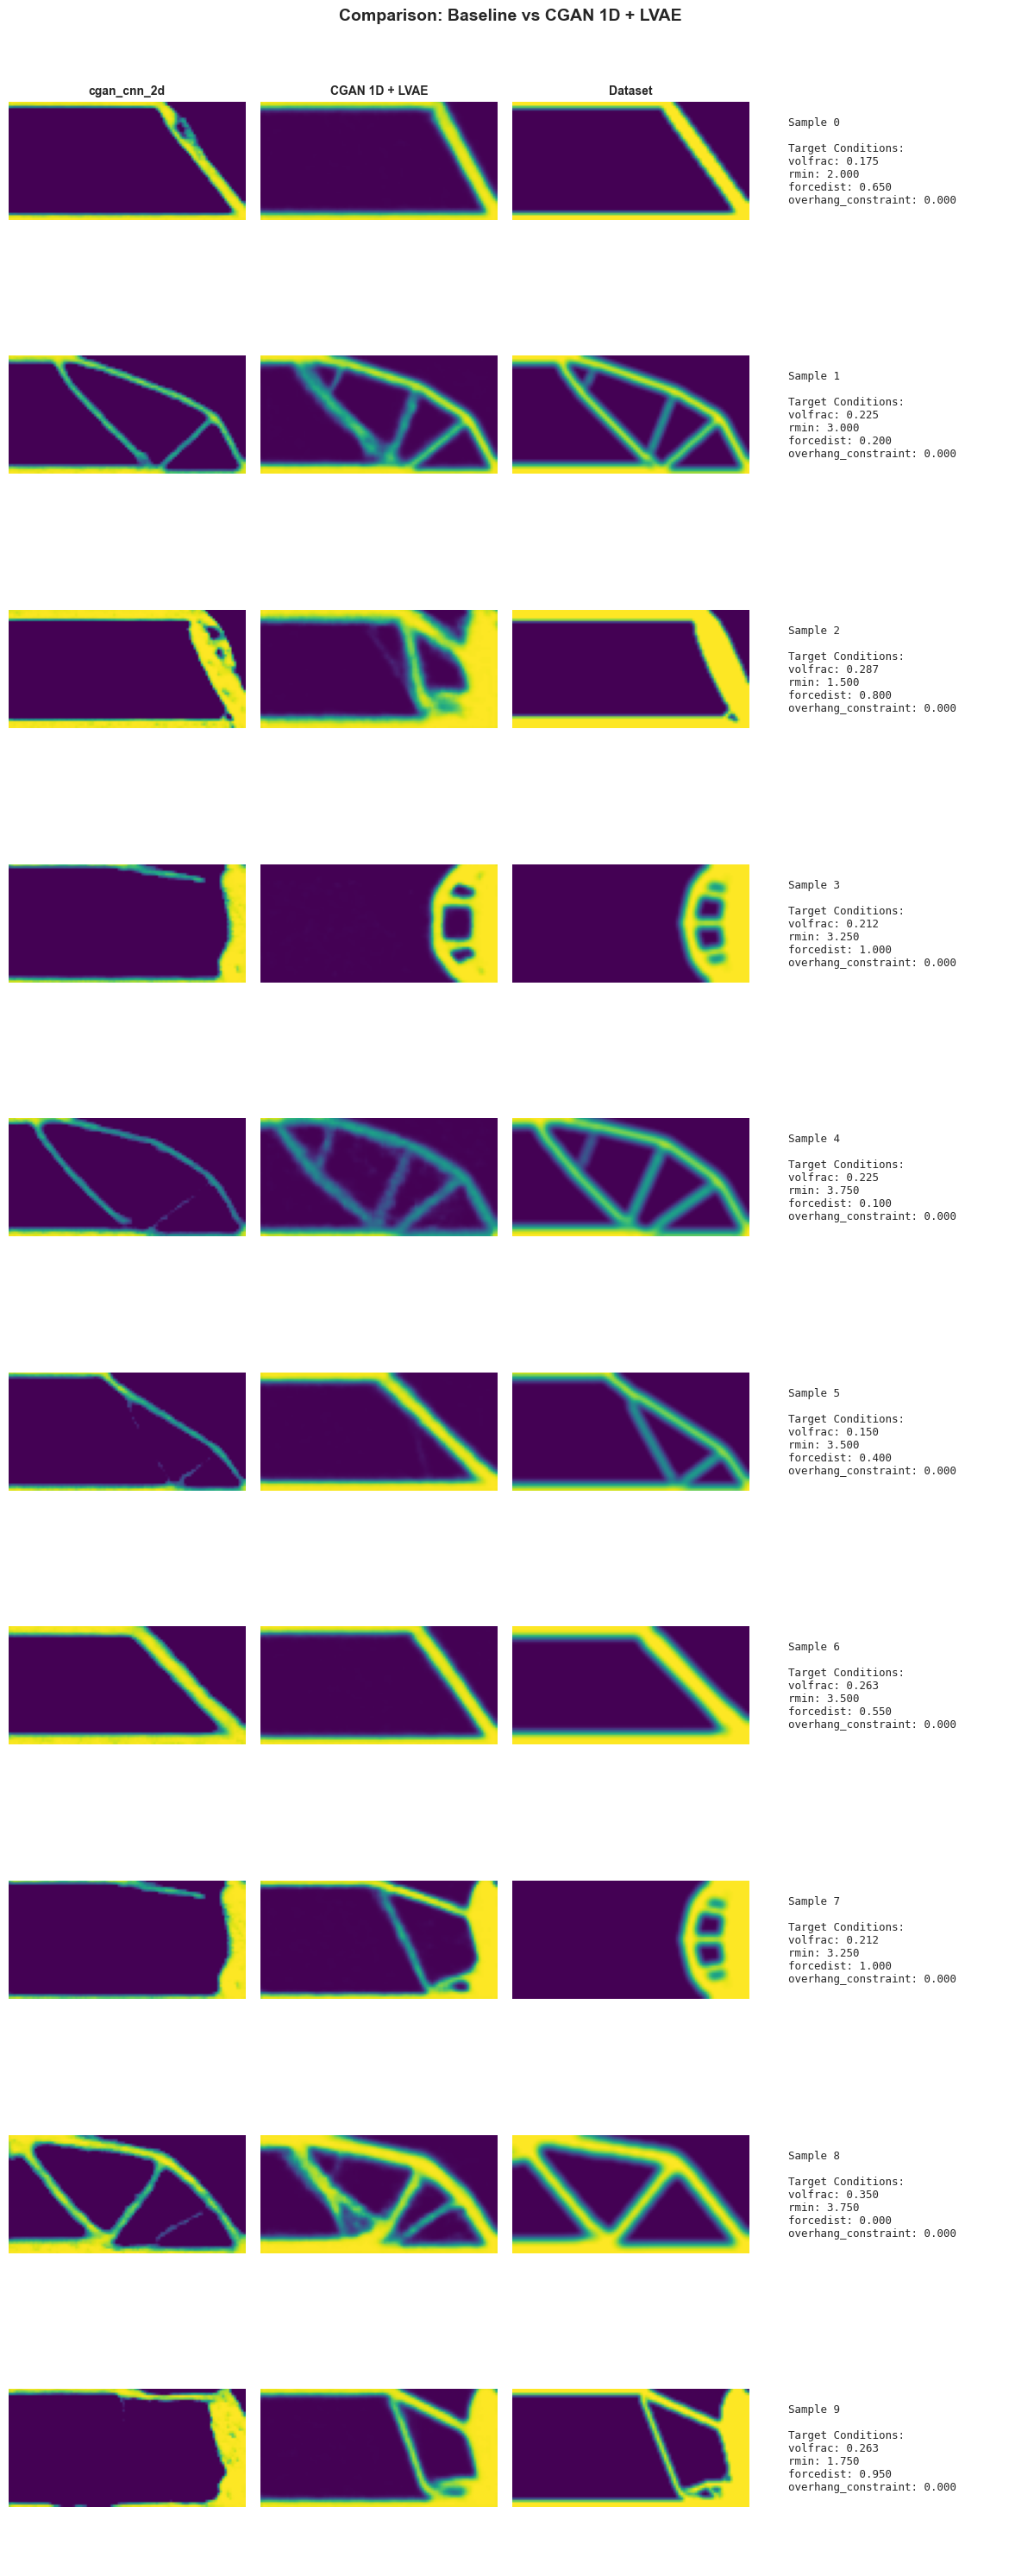

In [154]:
# Side-by-side comparison of baseline LVAE vs CGAN 1D + LVAE
n_comparison_samples = min(10, N_SAMPLES)

fig, axes = plt.subplots(n_comparison_samples, 4, figsize=(12, 3 * n_comparison_samples))

for i in range(n_comparison_samples):
    # Baseline LVAE (unconditional)
    axes[i, 0].imshow(gen_designs_np[i], cmap='viridis', vmin=0, vmax=1)
    if i == 0:
        axes[i, 0].set_title(MODEL_TYPE, fontsize=10, fontweight='bold')
    axes[i, 0].axis('off')
    
    # CGAN 1D + LVAE (conditional)
    axes[i, 1].imshow(gen_designs_cgan1d_np[i], cmap='viridis', vmin=0, vmax=1)
    if i == 0:
        axes[i, 1].set_title("CGAN 1D + LVAE", fontsize=10, fontweight='bold')
    axes[i, 1].axis('off')
    
    # Target conditions
    axes[i, 2].imshow(sampled_designs_np[i], cmap='viridis', vmin=0, vmax=1)
    if i == 0:
        axes[i, 2].set_title("Dataset", fontsize=10, fontweight='bold')
    axes[i, 2].axis('off')

    # Target conditions
    cond_str = "\n".join([f"{k}: {conditions_np[j, i]:.3f}"
                          for j, k in enumerate(problem.conditions_keys)])
    axes[i, 3].text(0.1, 0.5, f"Sample {i}\n\nTarget Conditions:\n{cond_str}", 
                    fontsize=9, verticalalignment='center', family='monospace')
    axes[i, 3].axis('off')

plt.suptitle("Comparison: Baseline vs CGAN 1D + LVAE", fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [174]:
from ipywidgets import interact, FloatSlider, VBox, HBox, Output, Label
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Sort conditions by each condition key
sorted_indices = {}
sorted_conditions = {}

for j, key in enumerate(problem.conditions_keys):
    # Get condition values for this key
    cond_values = conditions_np[j, :]
    # Sort indices by increasing condition value
    sorted_idx = np.argsort(cond_values)
    sorted_indices[key] = sorted_idx
    sorted_conditions[key] = cond_values[sorted_idx]

print("Sorted conditions by each key:")
for key in problem.conditions_keys:
    print(f"\n{key}:")
    print(f"  Min: {sorted_conditions[key].min():.4f}")
    print(f"  Max: {sorted_conditions[key].max():.4f}")
    print(f"  Range: {sorted_conditions[key]}")

# Create sliders for each condition
sliders = {}
for j, key in enumerate(problem.conditions_keys):
    min_val = float(sorted_conditions[key].min())
    max_val = float(sorted_conditions[key].max())
    
    sliders[key] = FloatSlider(
        value=min_val,
        min=min_val,
        max=max_val,
        step=(max_val - min_val) / 100,
        description=f'{key}:',
        continuous_update=True,
        readout=True,
        readout_format='.4f',
    )

# Function to find the closest sample to slider values
def find_closest_sample(**slider_values):
    # Calculate distance to each sample
    distances = np.zeros(N_SAMPLES)
    
    for j, key in enumerate(problem.conditions_keys):
        target_value = slider_values[key]
        # Normalize by range to give equal weight to each condition
        cond_range = sorted_conditions[key].max() - sorted_conditions[key].min()
        if cond_range > 0:
            distances += ((conditions_np[j, :] - target_value) / cond_range) ** 2
        else:
            distances += (conditions_np[j, :] - target_value) ** 2
    
    # Find closest sample
    closest_idx = np.argmin(distances)
    
    # Clear and display
    clear_output(wait=True)
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display generated design from original model
    axes[0].imshow(gen_designs_np[closest_idx], cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title(f'{MODEL_TYPE}\n(Closest Match)', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Display generated design from CGAN 1D + LVAE
    axes[1].imshow(gen_designs_cgan1d_np[closest_idx], cmap='viridis', vmin=0, vmax=1)
    axes[1].set_title('CGAN 1D + LVAE\n(Closest Match)', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Display dataset design
    axes[2].imshow(sampled_designs_np[closest_idx], cmap='viridis', vmin=0, vmax=1)
    axes[2].set_title('Dataset Design\n(Closest Match)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    # Add condition information as suptitle
    cond_info = []
    for j, key in enumerate(problem.conditions_keys):
        target = slider_values[key]
        actual = conditions_np[j, closest_idx]
        cond_info.append(f"{key}: target={target:.4f}, actual={actual:.4f}")
    
    fig.suptitle(f"Sample {closest_idx} | " + " | ".join(cond_info), 
                 fontsize=11, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nClosest sample: {closest_idx}")
    print(f"Distance: {np.sqrt(distances[closest_idx]):.6f}")
    print(f"\nCondition comparison:")
    for j, key in enumerate(problem.conditions_keys):
        target = slider_values[key]
        actual = conditions_np[j, closest_idx]
        diff = actual - target
        print(f"  {key:15s}: target={target:8.4f}, actual={actual:8.4f}, diff={diff:+8.4f}")

# Create interactive widget
interact(find_closest_sample, **sliders);

Sorted conditions by each key:

volfrac:
  Min: 0.1500
  Max: 0.4000
  Range: [0.15   0.15   0.1625 0.1625 0.1625 0.175  0.175  0.175  0.175  0.175
 0.175  0.175  0.175  0.175  0.175  0.1875 0.1875 0.1875 0.1875 0.1875
 0.1875 0.2    0.2    0.2    0.2    0.2    0.2125 0.2125 0.2125 0.225
 0.225  0.225  0.225  0.225  0.225  0.225  0.2375 0.25   0.2625 0.2625
 0.2625 0.2625 0.2625 0.2625 0.2625 0.2625 0.275  0.275  0.275  0.275
 0.2875 0.2875 0.2875 0.2875 0.2875 0.2875 0.2875 0.3    0.3    0.3
 0.3    0.3    0.3125 0.3125 0.325  0.325  0.325  0.325  0.325  0.325
 0.325  0.325  0.325  0.325  0.325  0.3375 0.3375 0.3375 0.35   0.35
 0.35   0.35   0.35   0.35   0.35   0.3625 0.375  0.375  0.375  0.3875
 0.3875 0.3875 0.3875 0.3875 0.3875 0.4    0.4    0.4    0.4    0.4   ]

rmin:
  Min: 1.5000
  Max: 4.0000
  Range: [1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.75
 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 2.   2.   2.   2.   2.   2.
 2.   2.   2.25 2.25 2.25 2.25 2.25 

interactive(children=(FloatSlider(value=0.15, description='volfrac:', max=0.4, min=0.15, readout_format='.4f',…